# Scale Scientific Analysis in the Cloud with AWS Lambda

### ***IMPORTANT (July 2023):**  This tutorial is in development and is still undergoing testing. Running code in AWS Lambda will incur charges in your AWS account. Cost scoping and benchmarking is not yet complete. Please proceed with caution.

This tutorial demonstrates how to plot a timeseries of global mean sea surface temperature values using AWS Lambda to perform the global mean computation. We use the MUR 25km dataset. 

This is one example of how to take advantage of AWS Cloud Computing capabilities for scientific research. Note that using AWS Compute services will incur costs that will be charged to your AWS account. As we complete testinng we will include estimates of the compute cost associated with this tutorial. Note that apexpanding the analysis to a longer time period or different dataset will affect the compute costs charged to your AWS account. 

## Prerequisite Steps: Set up AWS infrastructure

This tutorial takes advantage of numerous AWS Services including Lambda, Parameter Store, Elastic Compute Cloud (EC2), Elastic Container Registry (ECR), and Simple Storage Service (S3). Full documentation for setting up these services to run this tutorial is still being developed and will be linked here when complete. 

#### Deploy Lambda function using Terraform

AWS Lambda is compute service that runs code in response to events. The Lambda code is packaged in a Docker image, and we use Terraform to handle setting up the AWS services including the Lambda function.

The /terraform/ directory contains the terraform configuration files. Edit terraform.tfvars with the names you want to give the AWS Elastic Container Registry (ecr_repo), the AWS Lambda role (lambda_role), the prefix to use for the Earthdata login parameters, and the AWS profile name you use for your account (optional). For example:

    ecr_repo    = "podaac-sst"
    lambda_role = "podaac-sst-lambda-role"
    prefix      = "podaac"
    profile     = "saml-pub"

Run the following command to initialize the terraform configuration files:
    
    terraform init


Run terraform plan to check infrastructure state:
    
    terraform plan -out=tfplan

If there are no modifications to the infrastructure required and everything looks correct, apply the plan:
    
    terraform apply tfplan

#### Set up Earthdata credentials in AWS Parameter Store

In this tutorial the Lambda function reads data files from the Earthdata S3 bucket directly. To avoid hard-coding Earthdata credentials or packaging a .netrc file in the Docker image that deploys the Lambda code, we use the AWS parameter store to set the Earthdata credentials. This means that the same Lambda code can run without modification in any user environment and will assume the correct EDL that is set in the AWS Parameter Store. 

#### Set up S3 bucket to hold granules and results

The Lambda function writes the results of the calculation back to a NetCDF file. In this scenario, there will be one results file generated for each granule processed. The results files are saved to an S3 bucket, where they can persist or be downloaded for further analysis & plotting. You need to create the S3 bucket that the Lambda function will use to save the results files.

#### Test Lambda function

#### Connect to EC2 instance to run this notebook

This notebook cannot be run on a local computer, as it heavily depends on direct in-cloud access. To run this notebook in AWS, connect to an EC2 instance running in the us-west-2 region, [following the instructions in this tutorial](https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html). Once you have connected to the EC2 instance, you can clone this repository into that environment, install the required packages, and run this notebook. 



## Step 1: Log in to Earthdata

We use the [earthaccess](https://nsidc.github.io/earthaccess/)  Python library to handle Earthdata authentication for the initial query to find the granules of interest. 

In [24]:
import earthaccess
import json
import boto3
import s3fs
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
auth = earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 06/16/2023
Using .netrc file for EDL


In [3]:
granules = earthaccess.search_data(
    short_name='MUR25-JPL-L4-GLOB-v04.2',
    cloud_hosted=True,
    temporal=("2022-01-01", "2023-01-01")
)

Granules found: 365


In [4]:
granule_paths = [g.data_links(access='direct')[0] for g in granules]

In [5]:
for path in granule_paths:
    print(path)
    break

s3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20220101090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc


## Step 2: Invoke the Lambda function

Set up a boto3 session to connect to your AWS instance and invoke the Lambda function

In [6]:
session = boto3.Session(profile_name='saml-pub')

lambda_client = session.client('lambda', region_name='us-west-2')

s3_results_bucket = "podaac-sst"

for granule in granule_paths:
    lambda_payload = {"input_granule_s3path": granule, "output_granule_s3bucket": s3_results_bucket, "prefix":"podaac"}

    lambda_client.invoke(
        FunctionName="podaac-sst",
        InvocationType="Event",
        Payload=json.dumps(lambda_payload)
    )

## Step 3: Plot results as timeseries

Open the resulting global mean files in xarray:

In [17]:
# set up the connection to the S3 bucket holding the results
s3_results = s3fs.S3FileSystem(
    anon=False,
    profile='saml-pub'
)

s3_files = s3_results.glob("s3://" + s3_results_bucket + "/MUR25/*")


# iterate through s3 files to create a fileset
fileset = [s3_results.open(file) for file in s3_files]



In [16]:
# open all files as an xarray dataset
data = xr.open_mfdataset(fileset, combine='by_coords', engine='scipy')

In [18]:
data

<xarray.Dataset>
Dimensions:       (time: 365)
Coordinates:
  * time          (time) datetime64[ns] 2022-01-01T09:00:00 ... 2023-01-01T09...
Data variables:
    analysed_sst  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

Plot the data using matplotlib:

Text(0.5, 0, 'Date')

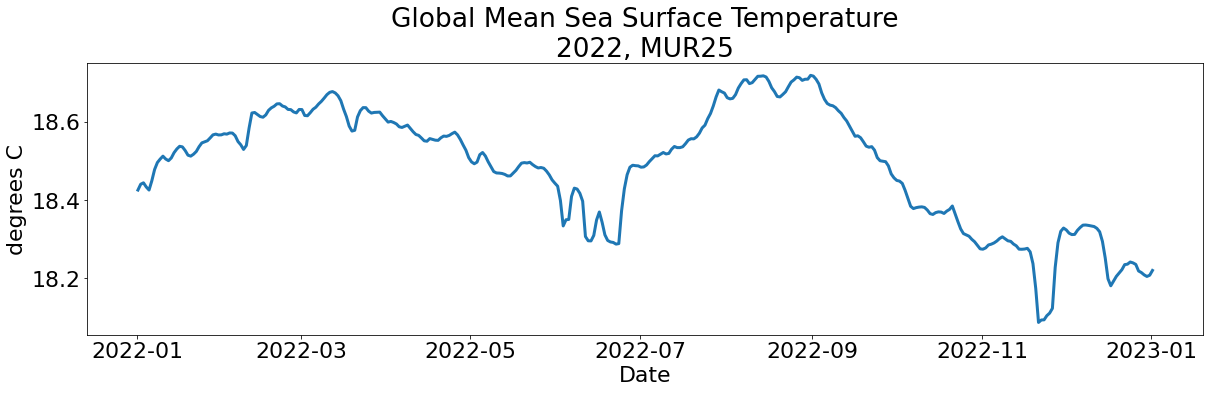

In [26]:
mpl.rcParams.update({'font.size': 22})

# set up the figure
fig = plt.Figure(figsize=(20,5))

# plot the data
plt.plot(data.time, data.analysed_sst, linewidth='3')
plt.title('Global Mean Sea Surface Temperature' + '\n' + '2022, MUR25')

plt.ylabel('degrees C')
plt.xlabel('Date')